In [327]:
#!pip install plotguy
#!pip install hkfdb
#!pip install yfinance --upgrade
#!pip install talib-binary

In [289]:
#!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
#!tar -xzvf ta-lib-0.4.0-src.tar.gz
#%cd ta-lib
#!./configure --prefix=/usr
#!make
#!make install
#!pip install Ta-Lib

In [290]:
import os
import sys
import copy
import datetime
import time
import itertools

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
#import plotguy

import yfinance as yf
import talib as ta
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns

In [291]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [292]:
#import own data manipulation toolkit
#sys.path.append('/content/drive/MyDrive/Colab Notebooks/Algorithmic trading/data')
#import _datatoolkit as dtk

**Defining Data Folder Structures**

In [293]:
#data folder structures
data_folder = '/content/drive/MyDrive/Colab Notebooks/Algorithmic trading/data'
backtest_output_folder = '/content/drive/MyDrive/Colab Notebooks/Algorithmic trading/backtest_output'

**1) Define Tickers List, Backtest Date Range and Data Retrival Intervals**

In [294]:
# define list of tickers to backtest
#ticker_list = ['ARCC', 'STAG', 'O', 'WPC', 'MAIN', 'ABR', 'ACRE', 'DIVO', 'JEPI', 'LTC', 'OHI', 'PFLT', 'QYLD', 'SCHD', 'STOR', 'XRMI']
ticker_list = ['IRM', 'WPC', 'UVXY', 'SQQQ', 'MOS', 'ARCC', 'HTGC', 'ACRE', 'ABR', 'CTO', 'O']

# define date range
start_date = '2021-03-20'
end_date = '2022-12-31'
interval = '1d'

# initial capital in USD
initial_capital = 8000

# position sizing
pos_size = round(initial_capital/len(ticker_list),2)

**2) Getting OHLC Data from Yahoo Finance** </b>


*   Get stock data based on ticker list from Yahoo Finance
*   Create each stock data as different dataframe
*   Add Technical Analysis indicators from TA-Lib
*   Pointing working directory to data folder, export dach dataframe as independent csv file 





In [295]:
# changing working directory to data folder's path
data_folder = '/content/drive/MyDrive/Colab Notebooks/Algorithmic trading/data'
os.chdir(data_folder)

# getting OHLC data from yfinance package, if auto_adjust=True, OHLC data will not have adj close column, use progress=False to get rid of comments
# Other indicators: 14 day RSI
for ticker in ticker_list:
  try:
    globals()[ticker] = pd.DataFrame
    globals()[ticker] = yf.download(ticker, start=start_date, end=end_date, interval=interval, auto_adjust=True, back_adjust=True, progress=False)
    globals()[ticker]['50EMA'] = ta.EMA(globals()[ticker]['Close'], timeperiod=50)
    globals()[ticker]['200EMA'] = ta.EMA(globals()[ticker]['Close'], timeperiod=200) 
    globals()[ticker]['ATR'] = ta.ATR(globals()[ticker]['High'], globals()[ticker]['Low'], globals()[ticker]['Close'], timeperiod=14)
    globals()[ticker]['RSI'] = ta.RSI(globals()[ticker]['Close'], timeperiod=14)
    globals()[ticker]['MACD'], globals()[ticker]['MACD_signal'], globals()[ticker]['MACD_hist'] = ta.MACD(globals()[ticker]['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    globals()[ticker]['ADX'] = ta.ADX(globals()[ticker]['High'], globals()[ticker]['Open'], globals()[ticker]['Close'], 14)
    globals()[ticker] = globals()[ticker].drop(['Volume', 'MACD_hist'], axis=1)
    globals()[ticker] = globals()[ticker].round(4).dropna()
    globals()[ticker] = globals()[ticker].reset_index()
    globals()[ticker]['Position'] = 0
    globals()[ticker][['Equity Value', 'MDD_dollar', 'PNL', 'Holding Period']] = np.NAN
    
    #writing each ticker dataframe into separate .csv files, save to google drive
    #globals()[ticker].to_csv(ticker+'.csv', index=False, header=True)
  except:
    print(globals()[ticker])

**Other Optional Indicators:** </b>

**MACD_hist** - globals()[ticker]['MACD'], globals()[ticker]['MACD_signal'], globals()[ticker]['MACD_hist'] = ta.MACD(globals()[ticker]['Close'], fastperiod=12, slowperiod=26, signalperiod=9) </b>

**ADXR** - globals()[ticker]['ADXR'] = ta.ADXR(globals()[ticker]['High'], globals()[ticker]['Open'], globals()[ticker]['Close'], 14)


**3) Building the DataFrame List, Perform Backtesting**

In [296]:
#df_list = [ARCC, STAG, O, WPC, MAIN, ABR, ACRE, DIVO, JEPI, LTC, OHI, PFLT, QYLD, SCHD, STOR, XRMI]
df_list = [IRM, WPC, UVXY, SQQQ, MOS, ARCC, HTGC, ACRE, ABR, CTO, O]

**Back Testing** </b>


*   Backtesting of Trade Logic across all tickers and in the designated timeframe
*   Backtesting for Trade strategy with simulated PNL



In [297]:
# function to extract dataframe name
def get_df_name(df):
   name =[x for x in globals() if globals()[x] is df][0]
   return name

In [298]:
trade_list = []
pos_size = round(initial_capital/len(ticker_list),2)

def backtest_macd(df):
  df_name = get_df_name(df)
  #pos_size = 800
  pos_opened = False
  open_price  = 0
  close_price = 0
  hold_counter = 0
  
  pnl = 0
  pnl_list = []
  
  lot_size = 0
  initial_equity_value = 0
  initial_buy_price = 0
  stop_loss = initial_equity_value * 0.1
  profit_target = initial_equity_value * 1.06

  for i in range(len(df)):
    now_date        = df.loc[i, 'Date']
    now_open        = df.loc[i, 'Open']
    now_close       = df.loc[i, 'Close']
    now_50EMA       = df.loc[i, '50EMA']
    now_200EMA      = df.loc[i, '200EMA']
    now_rsi         = df.loc[i, 'RSI']
    now_MACD        = df.loc[i, 'MACD']
    now_MACD_signal = df.loc[i, 'MACD_signal']
    now_ADX         = df.loc[i, 'ADX']
    now_position    = df.loc[i, 'Position']
    now_equity_val  = df.loc[i, 'Equity Value']
    now_mdd_dollar  = df.loc[i, 'MDD_dollar']

    # opening a position
    if (pos_opened == False) and ((now_MACD > now_MACD_signal) and (now_rsi < 45)):
      pos_opened = True
      open_price = now_open
      lot_size = pos_size//open_price
      buy_commission = (0.0049 + 0.005) * lot_size
      initial_equity_value = round(((lot_size * open_price) - buy_commission),2)
      initial_buy_price = initial_equity_value/ lot_size
      hold_counter = hold_counter + 1
      df.loc[i, 'Position'] = 1
      df.loc[i, 'Equity Value'] = initial_equity_value
      trade_list.append([now_date, df_name, open_price, pos_opened, lot_size, initial_equity_value])
    
    # closing a position
    elif (pos_opened == True) and (now_MACD < now_MACD_signal) or ((pos_opened == True) and (now_date == df.loc[(len(df)-1), 'Date'])):
      pos_opened = False
      close_price = now_open
      sell_commission = (0.04 * lot_size) + (close_price * lot_size * 0.0000229)
      pnl = round(((close_price - initial_buy_price) * lot_size) - sell_commission,2)
      df.loc[i, 'Position'] = 2
      df.loc[i, 'Equity Value'] = (now_open * lot_size)
      df.loc[i, 'MDD_dollar']     = (now_close * lot_size) - initial_equity_value
      df.loc[i, 'PNL'] = pnl.round(2)
      df.loc[i, 'Holding period'] = hold_counter
      pnl_list.append(pnl)
      trade_list.append([now_date, df_name, close_price, pos_opened, lot_size, (close_price*lot_size), pnl, hold_counter])

      # reset values
      open_price = 0
      close_price = 0
      initial_equity_value = 0
      initial_buy_price = 0
      lot_size = 0
      stop_loss = 0
      hold_counter = 0

    # calculating daily drawdowns
    #else (pos_opened == True):
    elif (pos_opened==True):
      df.loc[i, 'Equity Value']   = (now_close * lot_size)
      df.loc[i, 'MDD_dollar']     = (now_close * lot_size) - round(initial_equity_value,2)
      hold_counter = hold_counter + 1
 
  total_profit = round(sum(pnl_list), 2)
  num_of_trade = round(len(pnl_list), 2)
  avg_pnl = round(total_profit/ num_of_trade, 2) if num_of_trade else 0
  max_mdd = df['MDD_dollar'].max().round(2)
  avg_hold_period = df['Holding period'].mean().round(2)

  return df_name, num_of_trade, total_profit, avg_pnl, max_mdd, avg_hold_period

**4) Projecting Total PNL** </br>


*   Creating for loop to simulate PNL based on particular strategy
*   Calculate portfolio PNL, ROI etc.



In [299]:
result_list = []

for df in df_list:
  try:
    df_name = get_df_name(df)
    test_result = backtest_macd(df)
    result_list.append(test_result)

    result_df = pd.DataFrame(result_list)
    result_df.columns = ['Ticker', 'No of Trade', 'Total PNL', 'Avg PNL/ Trade', 'Maximum Drawdown', 'Avg Holding Days']
  except: 
    None

In [310]:
measure_date = df_list[1].loc[1, 'Date']
end_date = df_list[1].loc[df.index[-1], 'Date'] 
print('Trade period:', (measure_date.strftime('%Y-%m-%d')), 'to', end_date.strftime('%Y-%m-%d'))
ROI = ((result_df['Total PNL'].sum()/ initial_capital)*100).round(2)
MDD = result_df['Maximum Drawdown'].mean().round(2)
print('Total No of Trades Executed:', (result_df['No of Trade'].sum()))
print('Total PNL: USD', result_df['Total PNL'].sum().round(2))
print('Required Capital: USD', initial_capital)
print('ROI: ', ROI, '%')
print('Avg MDD: USD', MDD)
result_df.sort_values(by=['Total PNL', 'Avg PNL/ Trade'], ascending=False)

Trade period: 2022-01-04 to 2022-11-30
Total No of Trades Executed: 34
Total PNL: USD 2038.59
Required Capital: USD 8000
ROI:  25.48 %
Avg MDD: USD 207.31


,Ticker,No of Trade,Total PNL,Avg PNL/ Trade,Maximum Drawdown,Avg Holding Days
3,SQQQ,1,375.58,375.58,528.40,33.00
8,ABR,5,279.79,55.96,180.63,14.20
6,HTGC,4,246.82,61.70,212.09,18.75
2,UVXY,3,241.42,80.47,454.22,19.33
0,IRM,4,197.87,49.47,126.00,17.75
1,WPC,4,192.34,48.08,113.70,18.75
5,ARCC,3,135.80,45.27,108.51,21.67
4,MOS,3,134.04,44.68,278.79,15.00
7,ACRE,4,101.81,25.45,113.89,16.50
10,O,1,88.28,88.28,98.50,33.00


**5) Detailed Portfolio Transaction List**

In [301]:
# full trading transactions across everything
full_trade = pd.DataFrame(trade_list)
full_trade.columns = ['Transaction Date', 'Ticker', 'Buy/Sell Price', 'Trade Opened', 'Lot Size', 'Ttl Equity Value', 'PNL', 'Holding Days']

In [317]:
full_trade.head()

,Transaction Date,Ticker,Buy/Sell Price,Trade Opened,Lot Size,Ttl Equity Value,PNL,Holding Days
0,2022-02-08,IRM,43.5770,True,16.0,697.0700,NaN,NaN
1,2022-02-15,IRM,42.6708,False,16.0,682.7328,-14.99,5.0
2,2022-06-29,IRM,48.2981,True,15.0,724.3200,NaN,NaN
3,2022-07-13,IRM,46.5283,False,15.0,697.9245,-27.01,9.0
4,2022-07-26,IRM,46.4690,True,15.0,696.8900,NaN,NaN


In [313]:
trade_plot = full_trade[['Transaction Date', 'Ttl Equity Value', 'PNL']]

<ipython-input-323-bc5538d5d7ff>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  trade_plot.groupby('Transaction Date')['Ttl Equity Value', 'PNL'].sum().plot(figsize=(12,4))


Text(0.5, 1.0, 'Total Equity Value for the Trading Period')

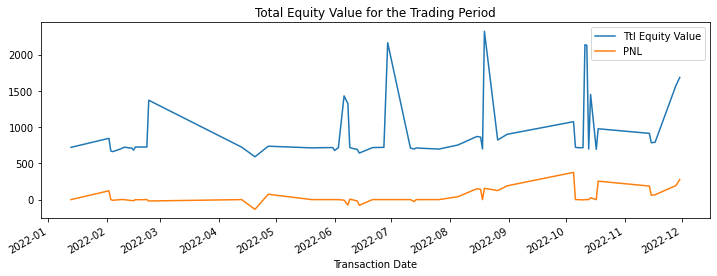

In [323]:
# graph plot - full year total equity value
trade_plot.groupby('Transaction Date')['Ttl Equity Value'].sum().plot(figsize=(12,4))
plt.title('Total Equity Value for the Trading Period')

In [303]:
full_trade[full_trade['Ticker'] == 'ABR']

,Transaction Date,Ticker,Buy/Sell Price,Trade Opened,Lot Size,Ttl Equity Value,PNL,Holding Days
52,2022-02-10,ABR,15.7032,True,46.0,721.8900,NaN,NaN
53,2022-02-14,ABR,15.4398,False,46.0,710.2308,-13.52,2.0
54,2022-02-16,ABR,15.4398,True,47.0,725.2100,NaN,NaN
55,2022-02-17,ABR,15.4307,False,47.0,725.2429,-1.86,1.0
56,2022-06-06,ABR,15.6342,True,46.0,718.7200,NaN,NaN
57,2022-06-08,ABR,15.3306,False,46.0,705.2076,-15.37,2.0
58,2022-06-29,ABR,12.6079,True,57.0,718.0900,NaN,NaN
59,2022-08-15,ABR,15.2678,False,57.0,870.2646,149.87,32.0
60,2022-10-12,ABR,11.9517,True,60.0,716.5100,NaN,NaN
61,2022-11-30,ABR,14.6600,False,60.0,879.6000,160.67,34.0


In [326]:
# Class to call Pandas by row and column
# https://stackoverflow.com/questions/28754603/indexing-pandas-data-frames-integer-rows-named-columns 
class XLocIndexer:
    def __init__(self, frame):
        self.frame = frame
    
    def __getitem__(self, key):
        row, col = key
        return self.frame.iloc[row][col]

pd.core.indexing.IndexingMixin.xloc = property(lambda frame: XLocIndexer(frame))